<a href="https://colab.research.google.com/github/punkmic/unsupervised-Sentiment-Analysis---Comparisen-analysis/blob/master/Unsupervised_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intro**

## **Install Dependecies**

In [1]:
%%capture
# install dependecies here
#!pip install langdetect  # for language detection
#!pip install diagrams # for visualize the workflow
#!pip install graphviz # for visualize the workflow
#!pip install Pillow # for image manipulation
!pip install textblob # for unsupervised sentiment analysis
!pip install wordcloud # for wordcloud plot
!pip install matplotlib # for plot
!pip install nltk # for natural language prepocessing
!pip install enelvo # for fix slangs, abbreviations, spelling errors
!pip install gensim # for topic modeling 
!pip install tabulate # for print as table
#!pip install transformers # for machine learning
!pip install numpy==1.21.6 # for mathematical
!pip install pyldavis # for model visualization
!pip install scikit-learn # machine learning

## **Load Depencies**

In [2]:
%%capture
# load dependecies here
#from langdetect import detect as dt
#from diagrams import Diagram as dg
#from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
import itertools
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams
from nltk.stem import PorterStemmer
sw = nltk.corpus.stopwords.words('portuguese')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("portuguese")
st = PorterStemmer()
import scipy
from scipy import spatial
import re
from textblob import TextBlob
from textblob import Word
import gensim
from gensim.models import Word2Vec
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.cluster
from sklearn.cluster import KMeans
from enelvo.normaliser import Normaliser
# We need this dataset in order to use the tokenizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Load Dataset**

### **Clone Github repository** 

In [3]:
# Files cloned from github may not automatically appear in files tab in this case right click and choose update
# this will update our files.
!git clone https://github.com/punkmic/unsupervised-Sentiment-Analysis---Comparisen-analysis.git
%cd /content/unsupervised-Sentiment-Analysis---Comparisen-analysis
!ls

fatal: destination path 'unsupervised-Sentiment-Analysis---Comparisen-analysis' already exists and is not an empty directory.
/content/unsupervised-Sentiment-Analysis---Comparisen-analysis
app.py		   models	     Unsupervised_Sentiment_Analysis.ipynb
clear_datasets.py  __pycache__	     webscraping.py
Drivers		   README.md	     wordclouds
LICENSE		   requirements.txt
Makefile	   results


In [4]:
# !git pull 

### **Load csv file**

In [5]:
PATH_TO_CSV = '/content/unsupervised-Sentiment-Analysis---Comparisen-analysis/results/web_scraping_results.csv'
df = pd.read_csv(PATH_TO_CSV, encoding='utf-8')
# lower colnames 
df.rename(columns={'Title':'title', 'Body':'body'}, inplace=True)

### **EDA**

In [6]:
print(f'Number of rows {df.shape[0]} \nNumber of columns {df.shape[1]}')

Number of rows 10 
Number of columns 2


In [7]:
print(df.dtypes)

title    object
body     object
dtype: object


In [8]:
from numpy import mean, median
text_length_list = df['body'].map(lambda x: len(x))
mean = mean(text_length_list)
median = median(text_length_list)
stats = df.describe(include='all')
print (f'Mean of sentences length: {mean} \nMedian of sentences length: {median} \n\n{stats}')

Mean of sentences length: 448.7 
Median of sentences length: 448.0 

                                                    title  \
count                                                  10   
unique                                                 10   
top     Recebi um e-mail que parte do pedido não foi p...   
freq                                                    1   

                                                     body  
count                                                  10  
unique                                                 10  
top     Olá!Preciso da ajuda de vocês para entender qu...  
freq                                                    1  


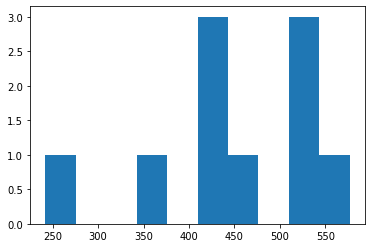

In [9]:
plt.hist(text_length_list)
plt.show()

## **Plot wordcloud**

In [10]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [11]:
# print currently directory
!pwd

/content/unsupervised-Sentiment-Analysis---Comparisen-analysis


In [12]:
# create a new directory for wordclouds
wordclouds = '/content/unsupervised-Sentiment-Analysis---Comparisen-analysis/results/wordclouds/'
!mkdir wordclouds

mkdir: cannot create directory ‘wordclouds’: File exists


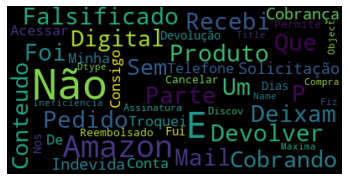

In [13]:
# Create and generate a word cloud image:
text = str(df['title']).title()
wordcloud = WordCloud(max_font_size=50, max_words=100,  stopwords=STOPWORDS).generate(text)

# Save wordcloud 
wordcloud.to_file('wordclouds/title_wordcloud.png')

# Display wordcloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



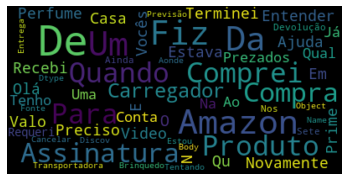

In [14]:

# Create and generate a word cloud image:
text = str(df['body']).title()
wordcloud = WordCloud(max_font_size=50, max_words=100).generate(text)

# Save wordcloud 
wordcloud.to_file('wordclouds/body_wordcloud.png')

# Display wordcloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



## **Text Pre-Processing**

Guide
* Lower Case conversion
* Removing Punctuations
* Stop Words Removal
* Rare Words Removal
* Spelling correction
* Tokenization
* Lemmatization



### **Apply enelvo - Normalize noisy words, lowercase the words and remove punctuation.**
Enelvo is a tool for normalising noisy words in user-generated content written in Portuguese -- such as tweets, blog posts, and product reviews. It is capable of identifying and normalising spelling mistakes, internet slang, acronyms, proper nouns, and others.

In [15]:
norm = Normaliser(tokenizer='readable', sanitize=True)
stemmer = SnowballStemmer('portuguese')

### **Process text**

In [16]:
def text_processing(df):
   # lower text
   df['body']= df['body'].apply(lambda x: ' '.join([x.lower() for x in x.split()]))
   # removal of stop words
   df['body'] = df['body'].apply(lambda x: ' '.join([x for x in x.split() if x not in sw]))
   # spelling Correction
   df['body'] = df['body'].apply(lambda x: norm.normalise(x) )
   # remove punctuations
   df['body'] = df['body'].str.replace('[^\w\s]', '')
   # removal of Numeric
   df['body'] = df['body'].str.replace('[0-9]', '')
   return df

In [17]:
df = text_processing(df)
df['body'][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


'olá preciso ajuda entender problema recebi email uns itens pagos fiz compra valor ar   cobrado cartão verificar itens deste pedido aparece valor ar   então parece pago dizem foi tão puderem estornar valor cobrado precisa enviar sabonetes obrigada'

## **Feature engineer**

### **Count vectors**

In [18]:
cv = CountVectorizer()
cv.fit(df['body'])
cv_tedfeatures = cv.transform(df['body'])
print(f"samples: {cv_tedfeatures.shape[0]}, features: {cv_tedfeatures.shape[1]}")

samples: 10, features: 279


### **TF-IDF Vectors**

In [19]:
tv = TfidfVectorizer()
tv.fit(df['body'])
tv_tedfeatures = tv.transform(df['body'])
print(f"samples: {tv_tedfeatures.shape[0]}, features: {tv_tedfeatures.shape[1]}")

# convert sparse matrix to dense
dense = tv_tedfeatures.todense()
denselist = dense.tolist()
tfid_df = pd.DataFrame(denselist,columns=tv.get_feature_names_out())
print()
print(tfid_df.iloc[:, 0:6])

samples: 10, features: 279

   absolutamente      acer   acessar    acesso    acordo       ado
0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1       0.000000  0.000000  0.000000  0.000000  0.133985  0.000000
2       0.155454  0.000000  0.000000  0.000000  0.000000  0.132150
3       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
4       0.000000  0.000000  0.130755  0.130755  0.000000  0.000000
5       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
6       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
7       0.000000  0.000000  0.000000  0.000000  0.000000  0.119756
8       0.000000  0.128522  0.000000  0.000000  0.000000  0.000000
9       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000


## **K-means Clustering**

### **Vectors as features**

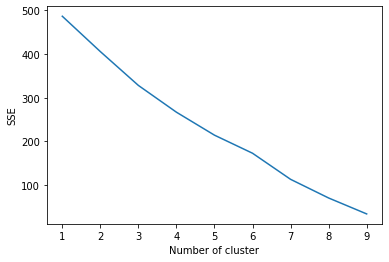

In [38]:
# Elbow method 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
elbow_method = {}
for k in range(1, 10):
  kmeans_elbow = KMeans(n_clusters=k).fit(cv_tedfeatures)
  elbow_method[k] = kmeans_elbow.inertia_
plt.figure()
plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [21]:
# Silhouette method 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
for n_cluster in range(2, 10):
  kmeans = KMeans(n_clusters=n_cluster).fit(cv_tedfeatures)
  label = kmeans.labels_
  sil_coeff = silhouette_score(cv_tedfeatures, label, metric='euclidean')
  print(f"For n_clusters={n_cluster}, The Silhouette Coefficient is {sil_coeff}")

For n_clusters=2, The Silhouette Coefficient is 0.12275043325389175
For n_clusters=3, The Silhouette Coefficient is 0.06002164095508711
For n_clusters=4, The Silhouette Coefficient is 0.05819059345301464
For n_clusters=5, The Silhouette Coefficient is 0.05428135314742374
For n_clusters=6, The Silhouette Coefficient is 0.03389646558179478
For n_clusters=7, The Silhouette Coefficient is 0.03239078472322965
For n_clusters=8, The Silhouette Coefficient is 0.030419304786093983
For n_clusters=9, The Silhouette Coefficient is 0.0042727099432998406


### **TF-IDF as features**

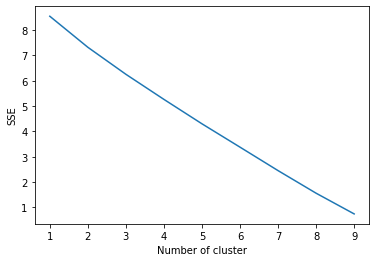

In [22]:
# Elbow method 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
elbow_method = {}
for k in range(1, 10):
  kmeans_elbow = KMeans(n_clusters=k).fit(tv_tedfeatures)
  elbow_method[k] = kmeans_elbow.inertia_
plt.figure()
plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [23]:
# Silhouette method 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
for n_cluster in range(2, 10):
  kmeans = KMeans(n_clusters=n_cluster).fit(tv_tedfeatures)
  label = kmeans.labels_
  sil_coeff = silhouette_score(cv_tedfeatures, label, metric='euclidean')
  print(f"For n_clusters={n_cluster}, The Silhouette Coefficient is {sil_coeff}")

For n_clusters=2, The Silhouette Coefficient is 0.047257637963629306
For n_clusters=3, The Silhouette Coefficient is 0.03532328315479835
For n_clusters=4, The Silhouette Coefficient is 0.053771569159734835
For n_clusters=5, The Silhouette Coefficient is 0.050651650216817966
For n_clusters=6, The Silhouette Coefficient is 0.03769142873850252
For n_clusters=7, The Silhouette Coefficient is -0.04569269007101796
For n_clusters=8, The Silhouette Coefficient is -0.024882694140998102
For n_clusters=9, The Silhouette Coefficient is -0.0015142821880752139


### **Clustering Mode**l

In [24]:
kmeans = KMeans(n_clusters=4).fit(tv_tedfeatures)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Number of cluster {kmeans.n_clusters} \nNumber of elements asigned to each cluster: {cluster_sizes} ")

Number of cluster 4 
Number of elements asigned to each cluster: [2 3 4 1] 


In [25]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print(f'\nCluster {i}')
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

clusters = KMeans(n_clusters=4, random_state=20).fit_predict(tv_tedfeatures)
get_top_keywords(tv_tedfeatures, clusters, tv.get_feature_names_out(), 10)


Cluster 0
prazo,correios,automático,devolver,código,dinheiro,dias,devolução,ainda,produto

Cluster 1
site,amazon,consigo,telefone,cadastro,opção,tudo,número,conta,cancelar

Cluster 2
seguinte,nova,sendo,ok,recebe,entregador,fazer,vieram,dia,entrega

Cluster 3
digital,deste,cobrando,cobrado,itens,venho,assinatura,cobrança,ar,valor


### **PCA and TSNE**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


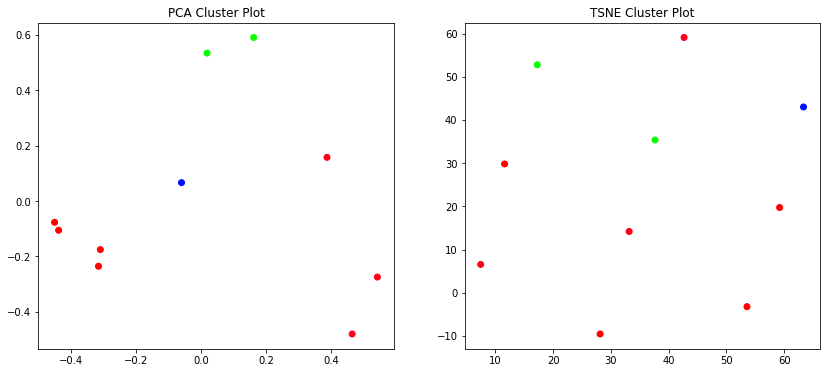

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=tv_tedfeatures.shape[0], replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=2).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=tv_tedfeatures.shape[0], replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(tv_tedfeatures, clusters)

In [27]:
ted_segmentaion = {'body':  df['body'] , 'cluster': kmeans.labels_.tolist()}
output_df = pd.DataFrame(ted_segmentaion)
#talks per segment
output_df['cluster'] = kmeans.labels_.tolist()
print(output_df.shape)


(10, 2)


### **Visualization of clusters**

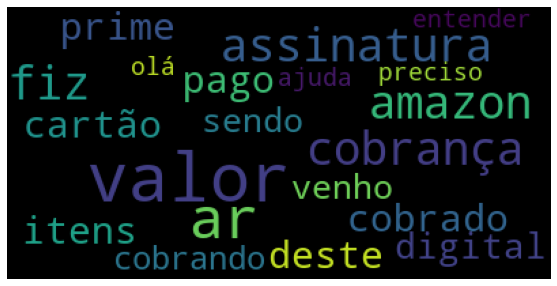

In [28]:
# cluster 1 visualization
from wordcloud import WordCloud, STOPWORDS
# Mono Gram
cluster = output_df[output_df.cluster == 1]
wordcloud = WordCloud(max_font_size=50, max_words=20, collocations = False).generate_from_text(' '.join(cluster['body']))
# Generate plot
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **Topic Modeling**

### **Create a dictionary using the bag of words model**
- Document: some text.
- Corpus: a collection of documents.

In [29]:
def process(doc):
  toks = [w for s in nltk.sent_tokenize(doc) for w in nltk.word_tokenize(s)]
  filt_toks = []
  for i in toks:
    if re.search('[a-zA-Z]', i):
      filt_toks.append(i)
  post_process = [st.stem(t) for t in filt_toks]
  return post_process

In [30]:
toks = [process(a) for a in cluster.body]
bodies = [[x for x in y if x not in sw] for y in toks]
print(f'Document 1, 10 first tokens: {bodies[0][:10]}')

Document 1, 10 first tokens: ['olá', 'preciso', 'ajuda', 'entend', 'problema', 'recebi', 'email', 'un', 'iten', 'pago']


In [31]:
from gensim import corpora

# associate each word in the corpus with a unique integer ID.
dictionary = corpora.Dictionary(bodies)

# create the bag-of-word representation for documents
corpus = [dictionary.doc2bow(text) for text in bodies]

print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 91
Number of documents: 3


### **Preview Bag Of Words**

In [32]:
# print how many times each word appear
bow_doc = corpus[0] 
table_list = []
for i in range(len(bow_doc)):
    index = bow_doc[i][0]
    word = dictionary[bow_doc[i][0]]
    times = bow_doc[i][1]
    table_list.append([word, times])
print(tabulate(table_list[:10],headers=["Word", "Frequency"], tablefmt="github"))

| Word    |   Frequency |
|---------|-------------|
| ajuda   |           1 |
| aparec  |           1 |
| ar      |           2 |
| cartão  |           1 |
| cobrado |           2 |
| compra  |           1 |
| dest    |           1 |
| dizem   |           1 |
| email   |           1 |
| entend  |           1 |


### **Latent Dirichlet Allocation (LDA) model**

In [33]:
from gensim import models
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric

# Set up the callbacks loggers
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
convergence_logger = ConvergenceMetric(logger='shell')
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = bodies)

NUM_TOPICS = 5
iterations = 50
passes = 50

# train model
lda_model = models.ldamodel.LdaModel(corpus=corpus,
            id2word=dictionary,
            num_topics=NUM_TOPICS,
            eval_every=10,
            iterations=iterations,
            passes=passes,
            callbacks=[convergence_logger, perplexity_logger, coherence_cv_logger])

# Save models so they aren't lost
if not os.path.exists(f"models/lda_{iterations}i50p/"):
   os.makedirs(f"models/lda_{iterations}i50p/")

lda_model.save(f"models/lda_{iterations}i50p/lda_{iterations}i50p.model")

In [34]:
# print the score and topics for each document in corpus sorted by topic score
for index in range(len(corpus)):
  for index, score in sorted(lda_model[corpus[index]], key=lambda x:x[1], reverse=True):
      print(f"\nScore: {score}\t \nTopic: {lda_model.print_topic(index, 8)}")


Score: 0.9783310294151306	 
Topic: 0.059*"valor" + 0.041*"pago" + 0.041*"iten" + 0.041*"cobrado" + 0.041*"ar" + 0.022*"fiz" + 0.022*"cartão" + 0.022*"dest"

Score: 0.9832733273506165	 
Topic: 0.034*"cobrança" + 0.018*"anual" + 0.018*"bloquei" + 0.018*"aqui" + 0.018*"seri" + 0.018*"consta" + 0.018*"tard" + 0.018*"contratei"

Score: 0.9783167243003845	 
Topic: 0.059*"valor" + 0.059*"ar" + 0.041*"assinatura" + 0.041*"amazon" + 0.041*"cobrando" + 0.041*"venho" + 0.022*"fiz" + 0.022*"digit"


### **Visualization of topics**

In [35]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
def show_topics(model):
  return gensimvis.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [36]:
show_topics(lda_model)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.123583  0.052984       1        1  39.163407
0     -0.001215 -0.127093       2        1  29.926735
3      0.133674  0.048674       3        1  29.926150
1     -0.004438  0.012718       4        1   0.491854
4     -0.004438  0.012718       5        1   0.491854, topic_info=          Term      Freq     Total Category  logprob  loglift
2           ar  3.000000  3.000000  Default  30.0000  30.0000
17        pago  1.000000  1.000000  Default  29.0000  29.0000
4      cobrado  1.000000  1.000000  Default  28.0000  28.0000
14        iten  1.000000  1.000000  Default  27.0000  27.0000
76    cobrando  1.000000  1.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
64       sendo  0.006432  1.790496   Topic5  -4.5108  -0.3142
44    cobrança  0.006432  2.505321   Topic5  -4.5108  -0.6501
39  assinatura  0.006432  2.447542   Topic5  -4.5108  -0.6268
33      amazon  0.006432  2.447542   Topic5  -4.5108  -0.6268
2           ar  0.006432  3.703906   Topic5  -4.5109  -1.0411

[207 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
30        1  0.882262  absolutament
31        1  0.882262           ado
32        1  0.882262         agora
73        2  0.929631       aguardo
0         3  0.929635         ajuda
...     ...       ...           ...
28        2  0.394033         valor
28        3  0.394033         valor
89        2  0.577117         venho
29        3  0.929635     verificar
90        2  0.929631         video

[101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2, 5])

### **Evaluating LDA model**

In [39]:
# perplexity is the measure of uncertainty, meaning lower the perplexity better the model.
print('Perplexity: ', lda_model.log_perplexity(corpus))

# Coherence is the measure of semantic similarity between top words in our topic. Higher the coherence better the model performance.
coherence_model_lda = models.CoherenceModel(model=lda_model, texts=bodies, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -5.060792616435459
Coherence Score:  0.6886386639864471


### **TF-IDF model**

The tf-idf model transforms vectors from the bag-of-words representation to a vector space where the frequency counts are weighted according to the relative rarity of each word in the corpus.

More rarity a word is more weighted a word is.

In [ ]:
# train the model
tfidf_model = models.TfidfModel(corpus, id2word=dictionary)

In [ ]:
# print the weight of each word in one document sorted by weight
table = []
for id, weight in sorted(tfidf_model[corpus[5]], key=lambda x: x[1], reverse=True):
    word = dictionary[id]
    table.append([word, weight])
print(tabulate(table, headers=["Word", "TF-IDF Weight"], tablefmt="github"))

### **Visualize topics**

In [ ]:
# code

### **Evaluate model**

In [ ]:
# code

### **Latent Semantic Analysis (LSA) model** 

In [ ]:
# convert the vector from (bag-of-words integer counts) to (TfIdf real-valued weights)
tfidf_corpus = tfidf_model[corpus]
print(f'This corpus has {len(tfidf_corpus)} documents')

# train the model
lsa_model = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=300)
lsa_model.show_topics()

In [ ]:
# print the weight of each word in one document sorted by weight
table = []
for id, weight in sorted(lsa_model[corpus[2]], key=lambda x: x[1], reverse=True):
    word = dictionary[id]
    table.append([word, weight])
print(tabulate(table, headers=["Word", "Weight"], tablefmt="github"))

### **Evaluate model**

In [ ]:
# Coherence is the measure of semantic similarity between top words in our topic. Higher the coherence better the model performance.
coherence_model_lsa = models.CoherenceModel(model=lsa_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

### **Random Projections, RP**

In [ ]:
num_topics = len(dictionary)
rp_model = models.RpModel(tfidf_corpus, num_topics=num_topics)

In [ ]:
# print the weight of each word in one document sorted by weight
table = []
for id, weight in sorted(rp_model[tfidf_corpus[5]], key=lambda x: x[1], reverse=True):
    word = dictionary[id]
    table.append([word, weight])
print(tabulate(table, headers=["Word", "Weight"], tablefmt="github"))

### **Evaluate model**

### **Hierarchical Dirichlet Process, HDP** 

In [ ]:
hp_model = models.HdpModel(corpus, id2word=dictionary)

In [ ]:
table = []
for id, weight in sorted(hp_model[corpus[5]], key=lambda x: x[1], reverse=True):
  word = dictionary[id]
  table.append([word,weight])
print(tabulate(table, headers=["Word", "Weight"], tablefmt="github"))

### **Evaluate model**

In [ ]:
# Coherence is the measure of semantic similarity between top words in our topic. Higher the coherence better the model performance.
coherence_model_hp = models.CoherenceModel(model=hp_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_hp = coherence_model_hp.get_coherence()
print('Coherence Score: ', coherence_hp)

### **BERTimbau**

In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
# BERT Base
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

### **Texblob**

In [ ]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
def get_blob_sentiment(sentence):
  blob = TextBlob(sentence).sentiment
  return blob.polarity

### **Vader**

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
def get_vader_sentiment(sentence):
  vader = sid.polarity_scores(sentence)
  return vader['compound']

In [ ]:
df['TextBlob'] = df['body'].apply(lambda sentence: get_blob_sentiment(sentence))
df['Vader'] = df['body'].apply(lambda sentence: get_vader_sentiment(sentence))

A negative sentiment score means 
negative sentiment, and a positive sentiment score means positive sentiment. The higher 
the absolute value of the score, the more confident the system is about it

In [ ]:
df.head(10)

### **Clustering sentences with K-Means**

In [ ]:
import re
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split

## **Save Models to Google Cloud Storage**

In [ ]:
# import google cloud dependencies
#from google.colab import auth
#import uuid # for generate a unique identification for google bucket
# Define a project id in google cloud
#project_id = '<project_ID>'

#auth.authenticate_user()
# configure gsutil
## !gcloud config set project {project_id}
# set bucket name
##backet_name = f'sample-bucket-{uuid.uuid1()}'
## !gsuit mb gs://{bucket_name}

In [ ]:
# upload model to Google Cloud Storage
#!gsuit cp /tmp/name_of_file.txt gs://{bucket_name}/

# location of model
#download_location = f"https://console.cloud.google.com/storage/browser?project={project_id}"

# donwload model from Google Cloud Storage
#!gsuit cp gs://{bucket_name}/{filename} {download_location}

## **References**


[LangDetect](https://pypi.org/project/langdetect/) <br/>
[Diagrams](https://pypi.org/project/diagrams/) <br/>
[Graphviz](https://pypi.org/project/graphviz/) <br/>
[Beautifulsoap4](https://pypi.org/project/beautifulsoup4/) <br/>
[OpLexicon](https://www.inf.pucrs.br/linatural/wordpress/recursos-e-ferramentas/oplexicon/)